# Convolutional NNs for CIFAR 10

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://pytorch.org/tutorials/_images/cifar10.png", width=400, height=300)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

## 1. Download CIFAR10 with `torchvision`

In [3]:
import torch
from torchvision import datasets, transforms, utils

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
traindata = iter(trainloader)

images, labels = next(traindata)

print(images[1].shape)

torch.Size([3, 32, 32])


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize to pot
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

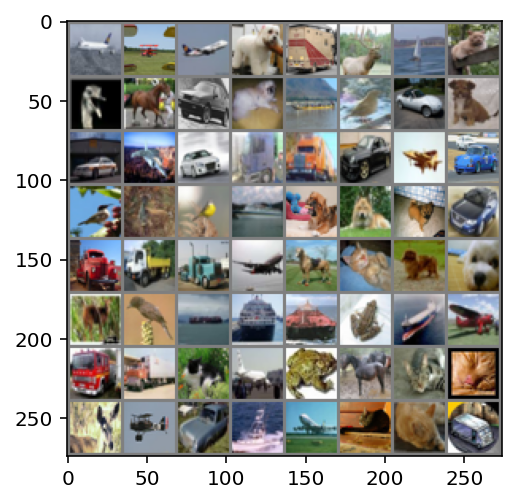

In [6]:
imshow(utils.make_grid(images))


Create a validation set using the 20% of train images:

In [7]:
n = trainloader.dataset.data.shape[0]

import copy

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 80% images for training
trainloader.dataset.data = trainloader.dataset.data[:int(n*0.8),:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:int(n*0.8)]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[int(n*0.8+1):,:,:]
validloader.dataset.targets = validloader.dataset.targets[int(n*0.8+1):]



## 2. Implement Lenet 5

Our first goal is to implement the LeNet 5 CNN network. The original paper is [here](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

In [3]:
Image(url= "https://engmrk.com/wp-content/uploads/2018/09/LeNet_Original_Image.jpg")

In the CNN network above we have 2 convolutional layers with the following properties:

- ReLU activation functions are used as non-linear functions
- Maxpooling with $2\times 2$ kernels is used to reduce the spatial dimension in both layers.
- $5\times 5$ convolutional filters are used. Stride is 1.
- After the second convolutional layer, three dense layers are stacked. 

Note that CIFAR-10 images are composed by **3 input color maps**, each of dimension $32\times32$.

In [9]:
class Lenet5(nn.Module):
    def __init__(self,dimx,nlabels):
        super().__init__()

        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, 
                               kernel_size=5, stride=1, padding=0)
        
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)

        # Linear layers
        self.linear1 = nn.Linear(400,120)
        self.linear2 = nn.Linear(120,84)
        self.linear3 = nn.Linear(84,10)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx-4)/2-4)/2)
        
    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.conv1(x) #YOUR CODE HERE
        x = self.relu(x) 
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # Flatten the tensor into a vector of appropiate dimension using self.final_dim
        x = x.view(-1,16*self.final_dim*self.final_dim)
        # Pass the tensor through the Dense Layers
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.logsoftmax(x) 
        return x


In [10]:
class CNN_extended(Lenet5):
        
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels)  
        
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()             
        self.loss_during_training = [] 
        self.valid_loss_during_training = []
        
    def trainloop(self,trainloader,validloader):
        
        for e in range(int(self.epochs)):
            running_loss = 0.
            for images, labels in trainloader:
                self.optim.zero_grad()
                out = self.forward(images)
                loss = self.criterion(out,labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()
            self.loss_during_training.append(running_loss/len(trainloader))
            
            
            with torch.no_grad():            
                running_loss = 0.
                for images,labels in validloader:                   
                  out = self.forward(images)
                  loss = self.criterion(out,labels)
                  running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    
            if(e % 1 == 0):
                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
                print("Validation loss after %d epochs: %f" 
                      %(e,self.valid_loss_during_training[-1]))
                
    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        with torch.no_grad():

            for images,labels in dataloader:
                probs = self.forward(images)
                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

In [11]:
my_CNN = CNN_extended(dimx=32,nlabels=10,epochs=5,lr=1e-3)
my_CNN.trainloop(trainloader,validloader)

Training loss after 0 epochs: 1.659075
Validation loss after 0 epochs: 1.453902
Training loss after 1 epochs: 1.386070
Validation loss after 1 epochs: 1.333296
Training loss after 2 epochs: 1.276827
Validation loss after 2 epochs: 1.251995
Training loss after 3 epochs: 1.197281
Validation loss after 3 epochs: 1.214041
Training loss after 4 epochs: 1.132257
Validation loss after 4 epochs: 1.194121


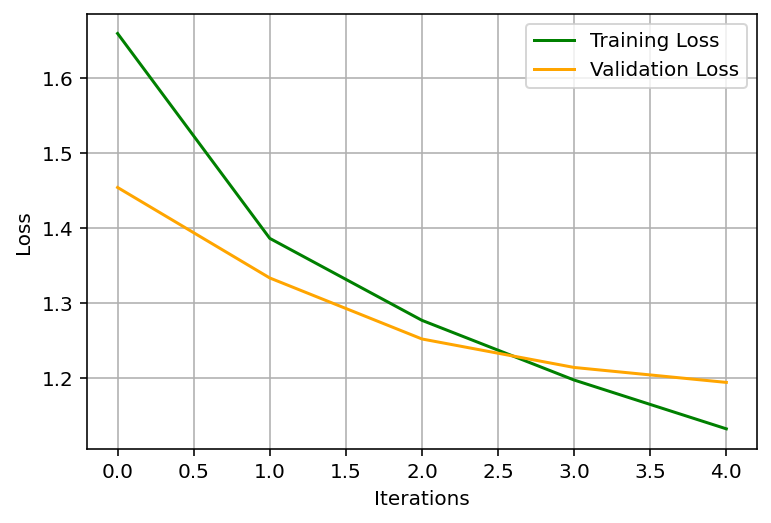

In [12]:
plt.plot(my_CNN.loss_during_training,'-b',label='Training Loss',color='g')
plt.plot(my_CNN.valid_loss_during_training,'-b',label='Validation Loss',color='orange')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid()

## 3.. GPU-based training

As was noticed, training became excessively slow. The newtork is already quite deep and gradient evaluation becomes a heavy operation. 

Therefore, we will now expand the previous code to one that implements the CNN training and validation using a GPU (if possible). 

In [ ]:
class Lenet5_extended_GPU(Lenet5):
        
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels)  
        
        self.lr = lr
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.to(self.device)
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            start_time = time.time()
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:
                
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)  
        
                self.optim.zero_grad()
                out = self.forward(images)
                loss = self.criterion(out,labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():            
                
                running_loss = 0.
                
                for images,labels in validloader:
                    
                    # Move input and label tensors to the default device
                    images, labels = images.to(self.device), labels.to(self.device)                 
                    
                    out = self.forward(images)
                    loss = self.criterion(out,labels)

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    

            if(e % 1 == 0): # Every 10 epochs

                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))
                
    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device) 
                probs = self.forward(images)

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

In [ ]:
my_CNN_GPU = Lenet5_extended_GPU(dimx=32,nlabels=10,epochs=5,lr=1e-3)

my_CNN_GPU.trainloop(trainloader,validloader)

Epoch 0. Training loss: 1.696630, Validation loss: 1.518114, Time per epoch: 20.250569 seconds
Epoch 1. Training loss: 1.405062, Validation loss: 1.365746, Time per epoch: 14.915822 seconds
Epoch 2. Training loss: 1.295201, Validation loss: 1.324652, Time per epoch: 14.971732 seconds
Epoch 3. Training loss: 1.212594, Validation loss: 1.250333, Time per epoch: 14.986442 seconds
Epoch 4. Training loss: 1.147547, Validation loss: 1.199138, Time per epoch: 14.912858 seconds


tensor(0.6141)
tensor(0.5786)


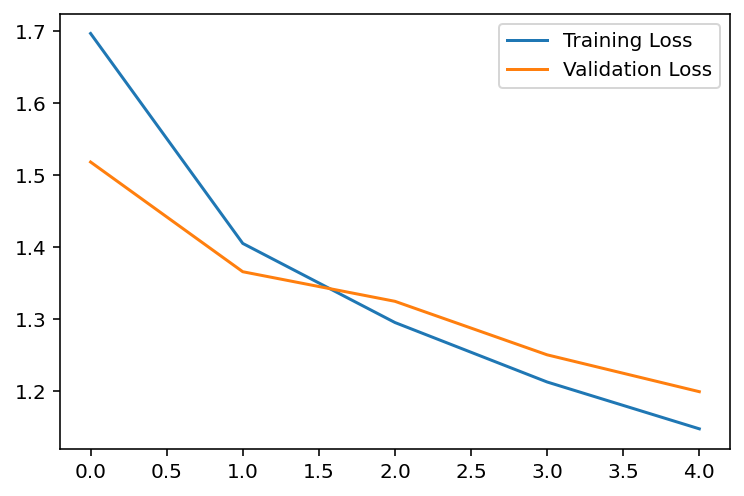

In [ ]:
plt.plot(my_CNN_GPU.loss_during_training,label='Training Loss')
plt.plot(my_CNN_GPU.valid_loss_during_training,label='Validation Loss')
plt.legend()

print(my_CNN_GPU.eval_performance(trainloader))
print(my_CNN_GPU.eval_performance(validloader))

## 4. Regularize the network and compare with a MLP

Epoch 0. Training loss: 1.699969, Validation loss: 1.507689, Time per epoch: 15.175013 seconds
Epoch 1. Training loss: 1.413428, Validation loss: 1.414162, Time per epoch: 15.852329 seconds
Epoch 2. Training loss: 1.288256, Validation loss: 1.281634, Time per epoch: 15.278988 seconds
Epoch 3. Training loss: 1.204378, Validation loss: 1.213783, Time per epoch: 15.572397 seconds
Epoch 4. Training loss: 1.145938, Validation loss: 1.217737, Time per epoch: 15.387130 seconds
Epoch 5. Training loss: 1.088493, Validation loss: 1.149049, Time per epoch: 15.200298 seconds
Epoch 6. Training loss: 1.042628, Validation loss: 1.135069, Time per epoch: 16.531771 seconds
Epoch 7. Training loss: 1.003510, Validation loss: 1.147199, Time per epoch: 15.527606 seconds
Epoch 8. Training loss: 0.960762, Validation loss: 1.120684, Time per epoch: 15.564744 seconds
Epoch 9. Training loss: 0.928542, Validation loss: 1.128420, Time per epoch: 15.375077 seconds
Epoch 10. Training loss: 0.894556, Validation loss

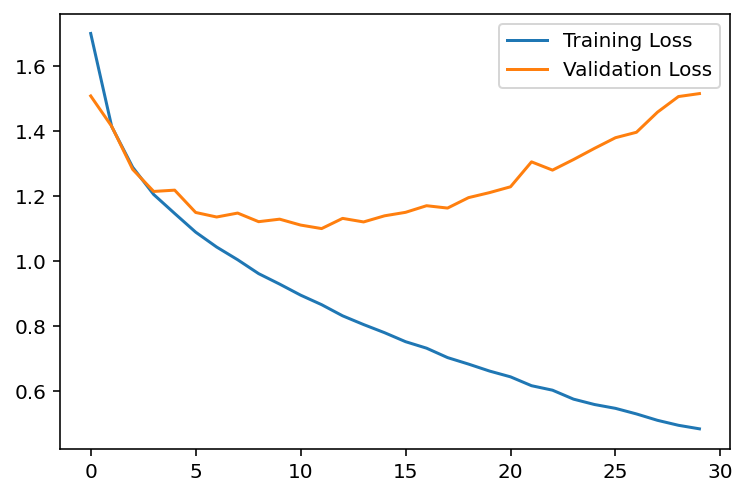

In [ ]:
# We can check that the CNN overfits by increasing the number of epochs. Eventually, we should see signs of overfitting
my_CNN_GPU = Lenet5_extended_GPU(dimx=32,nlabels=10,epochs=30,lr=1e-3)
my_CNN_GPU.trainloop(trainloader,validloader)

plt.plot(my_CNN_GPU.loss_during_training,label='Training Loss')
plt.plot(my_CNN_GPU.valid_loss_during_training,label='Validation Loss')
plt.legend()

print(my_CNN_GPU.eval_performance(trainloader))
print(my_CNN_GPU.eval_performance(validloader))
print(my_CNN_GPU.eval_performance(testloader))

In [ ]:
# Regularization: early stopping + dropout
# First, the early stopping should be done in epoch 11, as it's the lowest point from which we see a increasing trend in the validation loss
my_CNN_GPU = Lenet5_extended_GPU(dimx=32,nlabels=10,epochs=11,lr=1e-3)
my_CNN_GPU.trainloop(trainloader,validloader)

train_acc = my_CNN_GPU.eval_performance(trainloader)
valid_acc = my_CNN_GPU.eval_performance(validloader)
test_acc = my_CNN_GPU.eval_performance(testloader)

print(train_acc)
print(valid_acc)
print(test_acc)

Epoch 0. Training loss: 1.688318, Validation loss: 1.501917, Time per epoch: 14.683079 seconds
Epoch 1. Training loss: 1.416696, Validation loss: 1.359589, Time per epoch: 14.839931 seconds
Epoch 2. Training loss: 1.291933, Validation loss: 1.266756, Time per epoch: 14.774230 seconds
Epoch 3. Training loss: 1.203004, Validation loss: 1.234776, Time per epoch: 14.776889 seconds
Epoch 4. Training loss: 1.133035, Validation loss: 1.199708, Time per epoch: 15.776349 seconds
Epoch 5. Training loss: 1.076718, Validation loss: 1.149781, Time per epoch: 15.016515 seconds
Epoch 6. Training loss: 1.026179, Validation loss: 1.147366, Time per epoch: 18.431940 seconds
Epoch 7. Training loss: 0.982483, Validation loss: 1.119436, Time per epoch: 17.924612 seconds
Epoch 8. Training loss: 0.939248, Validation loss: 1.089512, Time per epoch: 17.231569 seconds
Epoch 9. Training loss: 0.897993, Validation loss: 1.142557, Time per epoch: 19.228684 seconds
Epoch 10. Training loss: 0.864208, Validation loss

tensor(0.6171)

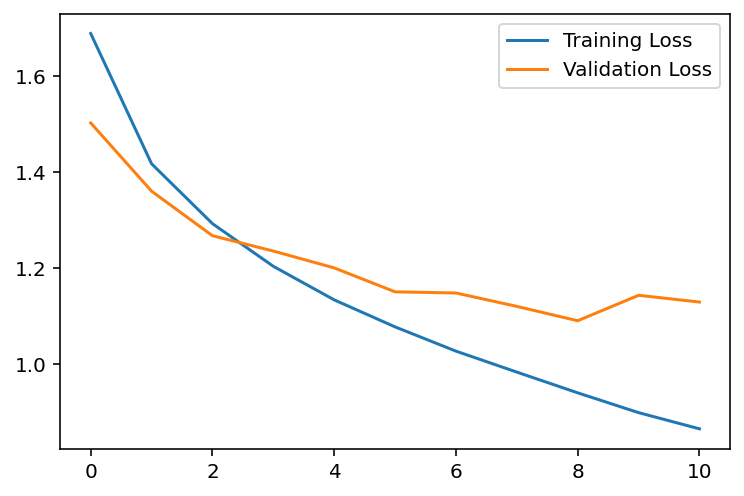

In [ ]:
plt.plot(my_CNN_GPU.loss_during_training,label='Training Loss')
plt.plot(my_CNN_GPU.valid_loss_during_training,label='Validation Loss')
plt.legend()
plt.grid()

In [ ]:
# Now the dropout (in between MLP layers)
# Need to change the forward method, so change the Lenet5 class
class Lenet5drop(nn.Module):
    def __init__(self,dimx,nlabels):
        super().__init__()

        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, 
                               kernel_size=5, stride=1, padding=0)
        
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.linear1 = nn.Linear(400,120)
        self.linear2 = nn.Linear(120,84)
        self.linear3 = nn.Linear(84,10)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        self.dropout = nn.Dropout(p=0.2) 
        self.final_dim = int(((dimx-4)/2-4)/2)
        
    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.conv1(x) 
        x = self.relu(x) 
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # Flatten the tensor into a vector of appropiate dimension using self.final_dim
        x = x.view(-1,16*self.final_dim*self.final_dim)
        # Pass the tensor through the Dense Layers
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.logsoftmax(x) 
        return x


In [ ]:
class Lenet5_extended_drop(Lenet5drop):
        
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels)  
        
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()             
        
        self.loss_during_training = [] 
        self.valid_loss_during_training = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            start_time = time.time()
            running_loss = 0.
            
            for images, labels in trainloader:
                images, labels = images.to(self.device), labels.to(self.device)  
        
                self.optim.zero_grad()
                out = self.forward(images)
                loss = self.criterion(out,labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()
                 
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
            
            with torch.no_grad():                            
                running_loss = 0.
                for images,labels in validloader:
                    images, labels = images.to(self.device), labels.to(self.device)                 
                    out = self.forward(images)
                    loss = self.criterion(out,labels)
                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
          
            if(e % 1 == 0): # Every 10 epochs
                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))
                
    def eval_performance(self,dataloader):
        loss = 0
        accuracy = 0

        with torch.no_grad():
            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device) 
                probs = self.forward(images)

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

In [ ]:
my_CNN_GPU = Lenet5_extended_drop(dimx=32,nlabels=10,epochs=50,lr=1e-3)
my_CNN_GPU.trainloop(trainloader,validloader)

train_acc = my_CNN_GPU.eval_performance(trainloader)
valid_acc = my_CNN_GPU.eval_performance(validloader)
test_acc = my_CNN_GPU.eval_performance(testloader)

print(train_acc)
print(valid_acc)
print(test_acc)

Epoch 0. Training loss: 1.791457, Validation loss: 1.602899, Time per epoch: 15.956408 seconds
Epoch 1. Training loss: 1.512673, Validation loss: 1.464580, Time per epoch: 18.706658 seconds
Epoch 2. Training loss: 1.383926, Validation loss: 1.362973, Time per epoch: 15.520686 seconds
Epoch 3. Training loss: 1.306777, Validation loss: 1.302557, Time per epoch: 15.439635 seconds
Epoch 4. Training loss: 1.244905, Validation loss: 1.286191, Time per epoch: 15.402086 seconds
Epoch 5. Training loss: 1.197902, Validation loss: 1.262991, Time per epoch: 15.594219 seconds
Epoch 6. Training loss: 1.159197, Validation loss: 1.223485, Time per epoch: 15.414405 seconds
Epoch 7. Training loss: 1.121799, Validation loss: 1.230908, Time per epoch: 15.148503 seconds
Epoch 8. Training loss: 1.090792, Validation loss: 1.210719, Time per epoch: 15.255896 seconds
Epoch 9. Training loss: 1.067157, Validation loss: 1.186466, Time per epoch: 15.504617 seconds
Epoch 10. Training loss: 1.043494, Validation loss

tensor(0.5902)

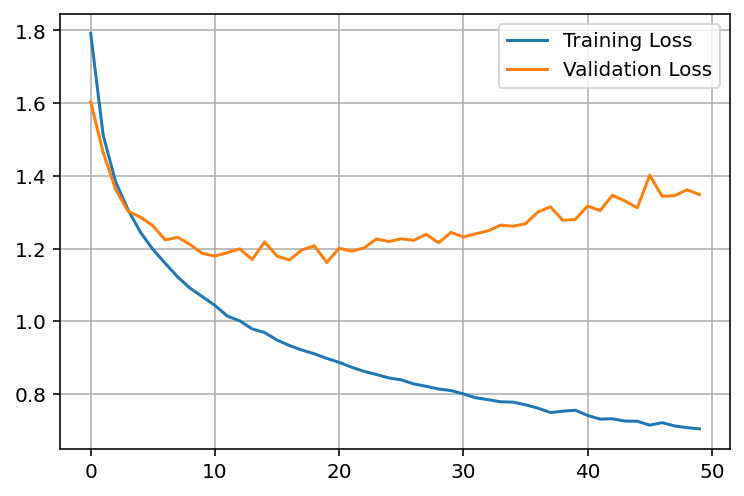

In [ ]:
plt.plot(my_CNN_GPU.loss_during_training,label='Training Loss')
plt.plot(my_CNN_GPU.valid_loss_during_training,label='Validation Loss')
plt.legend()
plt.grid()

In [ ]:
# To do early stopping now, we would use 19 epochs
my_CNN_GPU = Lenet5_extended_drop(dimx=32,nlabels=10,epochs=19,lr=1e-3)
my_CNN_GPU.trainloop(trainloader,validloader)

train_acc = my_CNN_GPU.eval_performance(trainloader)
valid_acc = my_CNN_GPU.eval_performance(validloader)
test_acc = my_CNN_GPU.eval_performance(testloader)

print(train_acc)
print(valid_acc)
print(test_acc)

Epoch 0. Training loss: 1.751535, Validation loss: 1.591519, Time per epoch: 15.202560 seconds
Epoch 1. Training loss: 1.493093, Validation loss: 1.458778, Time per epoch: 15.257088 seconds
Epoch 2. Training loss: 1.385627, Validation loss: 1.367016, Time per epoch: 15.240261 seconds
Epoch 3. Training loss: 1.314563, Validation loss: 1.314405, Time per epoch: 15.755650 seconds
Epoch 4. Training loss: 1.257525, Validation loss: 1.298905, Time per epoch: 15.450261 seconds
Epoch 5. Training loss: 1.217526, Validation loss: 1.280999, Time per epoch: 16.310722 seconds
Epoch 6. Training loss: 1.180073, Validation loss: 1.234812, Time per epoch: 16.155622 seconds
Epoch 7. Training loss: 1.146655, Validation loss: 1.239829, Time per epoch: 15.649521 seconds
Epoch 8. Training loss: 1.120637, Validation loss: 1.217146, Time per epoch: 15.634738 seconds
Epoch 9. Training loss: 1.094024, Validation loss: 1.197821, Time per epoch: 15.634499 seconds
Epoch 10. Training loss: 1.069101, Validation loss

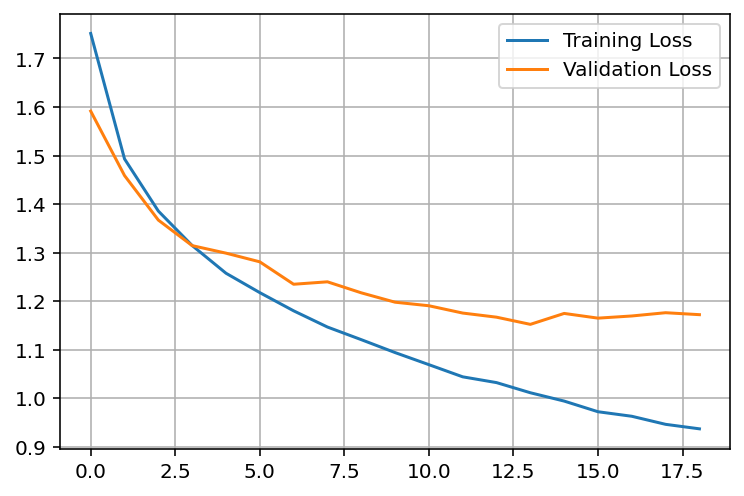

In [ ]:
plt.plot(my_CNN_GPU.loss_during_training,label='Training Loss')
plt.plot(my_CNN_GPU.valid_loss_during_training,label='Validation Loss')
plt.legend()
plt.grid()

# Part 2: Batch Normalization 

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

In [ ]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training  data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Using downloaded and verified file: /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Using downloaded and verified file: /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



In [ ]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,nlabels,use_batch_norm): #Nlabels will be 10 in our case
        
        super().__init__()
        
        # Keep track of whether or not this network uses batch normalization.
        self.use_batch_norm = use_batch_norm
        
        self.output1 = nn.Linear(dimx,hidden1)
        self.output2 = nn.Linear(hidden1,hidden2)        
        self.output3 = nn.Linear(hidden2,nlabels)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        if self.use_batch_norm:
            self.batch_norm1 = nn.BatchNorm1d(hidden1)
            self.batch_norm2 = nn.BatchNorm1d(hidden2)
            
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        if self.use_batch_norm:
            x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.output2(x)
        if self.use_batch_norm:
            x = self.batch_norm2(x)        
        x = self.relu(x)
        x = self.output3(x)
        x = self.logsoftmax(x) 
        return x

In [ ]:
n = trainloader.dataset.data.shape[0]

import copy

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 80% images for training
trainloader.dataset.data = trainloader.dataset.data[:int(n*0.8),:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:int(n*0.8)]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[int(n*0.8+1):,:,:]
validloader.dataset.targets = validloader.dataset.targets[int(n*0.8+1):]

In [ ]:
class MLP_extended(MLP):
    
    def __init__(self,dimx,hidden1,hidden2,nlabels,use_batch_norm,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1,hidden2,nlabels,use_batch_norm)
        
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()         
        self.loss_during_training = [] 
        self.valid_loss_during_training = [] 
        
    def trainloop(self,trainloader):
        
        # Optimization Loop
        for e in range(int(self.epochs)): 
            running_loss = 0.
            for images, labels in trainloader:
                self.optim.zero_grad()
                out = self.forward(images.view(images.shape[0], -1))
                loss = self.criterion(out,labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()
            self.loss_during_training.append(running_loss/len(trainloader))

            running_loss = 0.
            with torch.no_grad():
                for images,labels in validloader:
                  out = self.forward(images.view(images.shape[0], -1))
                  loss = self.criterion(out,labels)
                  running_loss += loss.item()
                self.valid_loss_during_training.append(running_loss/len(validloader))

            if(e % 1 == 0):
                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
                print("Validation loss after %d epochs: %f" 
                      %(e,self.valid_loss_during_training[-1]))

    def evaluate(self,loader):
        accuracy = 0

        with torch.no_grad():
            for images,labels in loader:
                logprobs = self.forward(images.view(images.shape[0], -1))
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        print("Accuracy %f" %(accuracy/len(loader)))

In [ ]:
net_batchnorm = MLP_extended(dimx=784,hidden1=256,hidden2=128,nlabels=10,use_batch_norm=True,epochs=30,lr=1e-3)
net_batchnorm.trainloop(trainloader)
train_acc = net_batchnorm.evaluate(trainloader)
valid_acc = net_batchnorm.evaluate(validloader)

Training loss after 0 epochs: 0.250745
Validation loss after 0 epochs: 0.144461
Training loss after 1 epochs: 0.093775
Validation loss after 1 epochs: 0.122397
Training loss after 2 epochs: 0.064507
Validation loss after 2 epochs: 0.114903
Training loss after 3 epochs: 0.049200
Validation loss after 3 epochs: 0.099542
Training loss after 4 epochs: 0.034844
Validation loss after 4 epochs: 0.121288
Training loss after 5 epochs: 0.032053
Validation loss after 5 epochs: 0.110542
Training loss after 6 epochs: 0.026508
Validation loss after 6 epochs: 0.120929
Training loss after 7 epochs: 0.022828
Validation loss after 7 epochs: 0.099724
Training loss after 8 epochs: 0.019641
Validation loss after 8 epochs: 0.098100
Training loss after 9 epochs: 0.020270
Validation loss after 9 epochs: 0.103357
Training loss after 10 epochs: 0.013074
Validation loss after 10 epochs: 0.111101
Training loss after 11 epochs: 0.015226
Validation loss after 11 epochs: 0.130832
Training loss after 12 epochs: 0.013

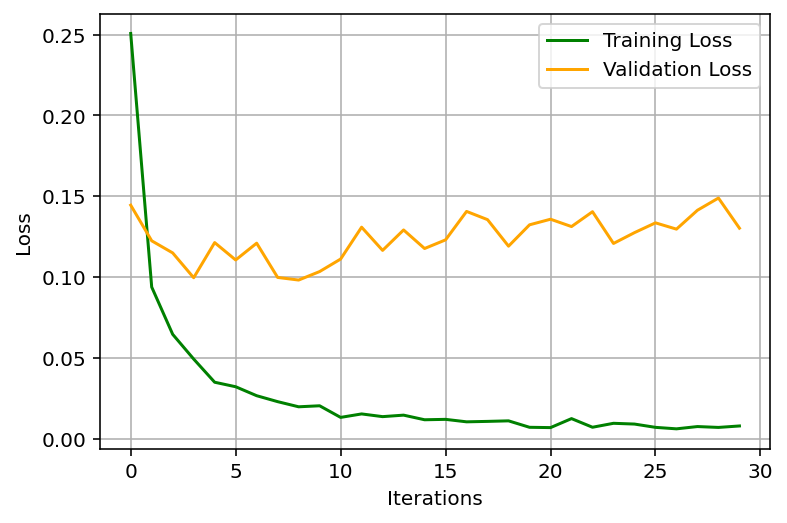

In [ ]:
plt.plot(net_batchnorm.loss_during_training,'-b',label='Training Loss',color='g')
plt.plot(net_batchnorm.valid_loss_during_training,'-b',label='Validation Loss',color='orange')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid()

In [ ]:
net_batchnorm = MLP_extended(dimx=784,hidden1=256,hidden2=128,nlabels=10,use_batch_norm=False,epochs=30,lr=1e-3)
net_batchnorm.trainloop(trainloader)
train_acc = net_batchnorm.evaluate(trainloader)
valid_acc = net_batchnorm.evaluate(validloader)
print(train_acc)
print(valid_acc)

Training loss after 0 epochs: 0.409160
Validation loss after 0 epochs: 0.250891
Training loss after 1 epochs: 0.190295
Validation loss after 1 epochs: 0.186918
Training loss after 2 epochs: 0.133256
Validation loss after 2 epochs: 0.168851
Training loss after 3 epochs: 0.106114
Validation loss after 3 epochs: 0.143975
Training loss after 4 epochs: 0.087007
Validation loss after 4 epochs: 0.136637
Training loss after 5 epochs: 0.074779
Validation loss after 5 epochs: 0.133013
Training loss after 6 epochs: 0.067292
Validation loss after 6 epochs: 0.119036
Training loss after 7 epochs: 0.058040
Validation loss after 7 epochs: 0.129315
Training loss after 8 epochs: 0.052524
Validation loss after 8 epochs: 0.117021
Training loss after 9 epochs: 0.044890
Validation loss after 9 epochs: 0.130840
Training loss after 10 epochs: 0.043117
Validation loss after 10 epochs: 0.129021
Training loss after 11 epochs: 0.039915
Validation loss after 11 epochs: 0.133429
Training loss after 12 epochs: 0.037

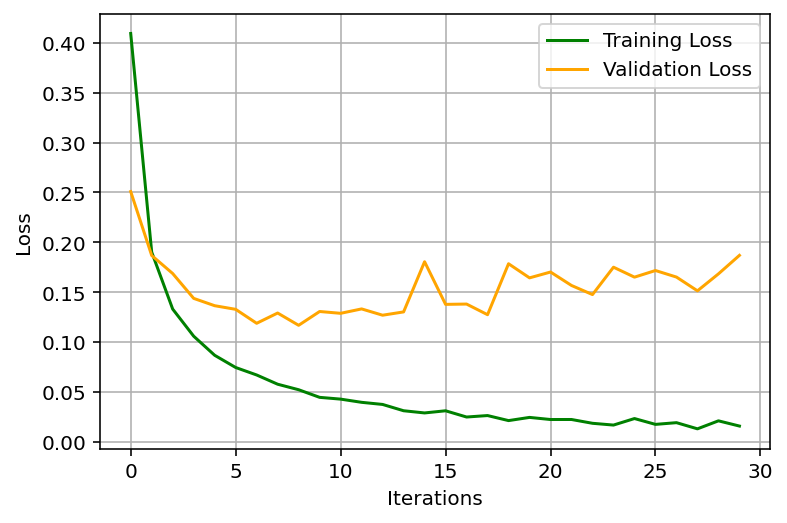

In [ ]:
plt.plot(net_batchnorm.loss_during_training,'-b',label='Training Loss',color='g')
plt.plot(net_batchnorm.valid_loss_during_training,'-b',label='Validation Loss',color='orange')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid()

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

import torch
from torchvision import datasets, transforms, utils

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


n = trainloader.dataset.data.shape[0]

import copy

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 80% images for training
trainloader.dataset.data = trainloader.dataset.data[:int(n*0.8),:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:int(n*0.8)]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[int(n*0.8+1):,:,:]
validloader.dataset.targets = validloader.dataset.targets[int(n*0.8+1):]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class Lenet5(nn.Module):
    def __init__(self,dimx,nlabels,use_batch_norm):
        super().__init__()

        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, 
                               kernel_size=5, stride=1, padding=0)
        
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)

        # Linear layers
        self.linear1 = nn.Linear(400,120)
        self.linear2 = nn.Linear(120,84)
        self.linear3 = nn.Linear(84,10)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx-4)/2-4)/2)

        self.use_batch_norm = use_batch_norm
        if self.use_batch_norm:
          self.batch_norm1 = nn.BatchNorm2d(6)
          self.batch_norm2 = nn.BatchNorm2d(16)

    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.conv1(x)
        if self.use_batch_norm:
          x = self.batch_norm1(x)
        x = self.relu(x) 
        x = self.pool(x)
        x = self.conv2(x)
        if self.use_batch_norm:
          x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.pool(x)
        # Flatten the tensor into a vector of appropiate dimension using self.final_dim
        x = x.view(-1,16*self.final_dim*self.final_dim)
        # Pass the tensor through the Dense Layers
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.logsoftmax(x) 
        return x

In [ ]:
class CNN_extended(Lenet5):
        
    def __init__(self,dimx,nlabels,use_batch_norm,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels,use_batch_norm)  
        
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()             
        self.loss_during_training = [] 
        self.valid_loss_during_training = []
        
    def trainloop(self,trainloader,validloader):
        
        for e in range(int(self.epochs)):
            running_loss = 0.
            for images, labels in trainloader:
                self.optim.zero_grad()
                out = self.forward(images)
                loss = self.criterion(out,labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()
            self.loss_during_training.append(running_loss/len(trainloader))
            
            with torch.no_grad():            
                running_loss = 0.
                for images,labels in validloader:                   
                  out = self.forward(images)
                  loss = self.criterion(out,labels)
                  running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    
            if(e % 1 == 0):
                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
                print("Validation loss after %d epochs: %f" 
                      %(e,self.valid_loss_during_training[-1]))
                
    def eval_performance(self,dataloader):
        loss = 0
        accuracy = 0

        with torch.no_grad():
            for images,labels in dataloader:
                probs = self.forward(images)
                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

In [ ]:
my_CNN = CNN_extended(dimx=32,nlabels=10,use_batch_norm=True,epochs=25,lr=1e-3)
my_CNN.trainloop(trainloader,validloader)

Training loss after 0 epochs: 1.522207
Validation loss after 0 epochs: 1.352294
Training loss after 1 epochs: 1.263191
Validation loss after 1 epochs: 1.211127
Training loss after 2 epochs: 1.160456
Validation loss after 2 epochs: 1.204792
Training loss after 3 epochs: 1.081442
Validation loss after 3 epochs: 1.085714
Training loss after 4 epochs: 1.017692
Validation loss after 4 epochs: 1.070003
Training loss after 5 epochs: 0.963738
Validation loss after 5 epochs: 1.050716
Training loss after 6 epochs: 0.919490
Validation loss after 6 epochs: 1.031369
Training loss after 7 epochs: 0.877609
Validation loss after 7 epochs: 1.026861
Training loss after 8 epochs: 0.840247
Validation loss after 8 epochs: 1.005370
Training loss after 9 epochs: 0.805692
Validation loss after 9 epochs: 1.013340
Training loss after 10 epochs: 0.778708
Validation loss after 10 epochs: 1.020259
Training loss after 11 epochs: 0.747463
Validation loss after 11 epochs: 1.018187
Training loss after 12 epochs: 0.720

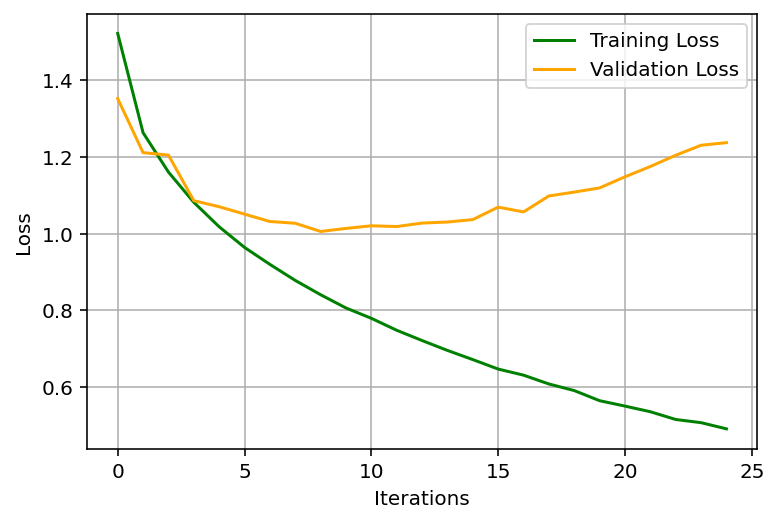

In [ ]:
plt.plot(my_CNN.loss_during_training,'-b',label='Training Loss',color='g')
plt.plot(my_CNN.valid_loss_during_training,'-b',label='Validation Loss',color='orange')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid()

In [ ]:
my_CNN = CNN_extended(dimx=32,nlabels=10,use_batch_norm=False,epochs=25,lr=1e-3)
my_CNN.trainloop(trainloader,validloader)

Training loss after 0 epochs: 1.699555
Validation loss after 0 epochs: 1.488191
Training loss after 1 epochs: 1.385980
Validation loss after 1 epochs: 1.335111
Training loss after 2 epochs: 1.261204
Validation loss after 2 epochs: 1.234373
Training loss after 3 epochs: 1.170987
Validation loss after 3 epochs: 1.163411
Training loss after 4 epochs: 1.097145
Validation loss after 4 epochs: 1.185723
Training loss after 5 epochs: 1.050599
Validation loss after 5 epochs: 1.098745
Training loss after 6 epochs: 1.002498
Validation loss after 6 epochs: 1.081317
Training loss after 7 epochs: 0.960352
Validation loss after 7 epochs: 1.080182
Training loss after 8 epochs: 0.921616
Validation loss after 8 epochs: 1.053457
Training loss after 9 epochs: 0.885641
Validation loss after 9 epochs: 1.093912
Training loss after 10 epochs: 0.854355
Validation loss after 10 epochs: 1.071070
Training loss after 11 epochs: 0.825289
Validation loss after 11 epochs: 1.066855
Training loss after 12 epochs: 0.796

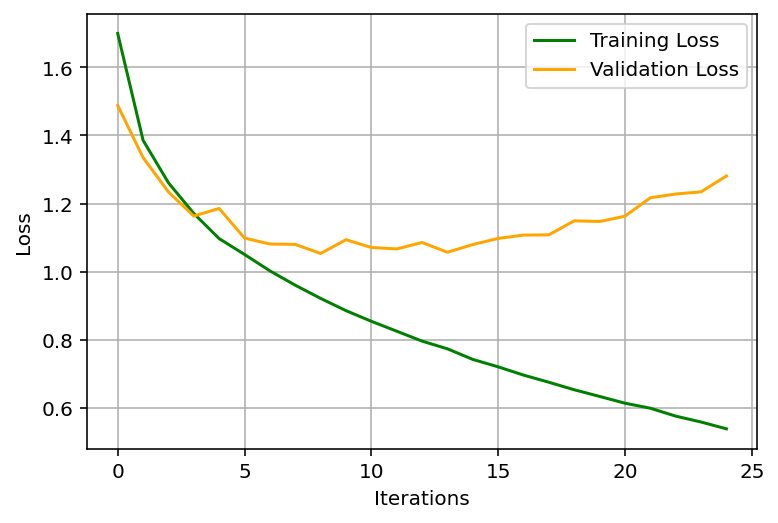

In [ ]:
plt.plot(my_CNN.loss_during_training,'-b',label='Training Loss',color='g')
plt.plot(my_CNN.valid_loss_during_training,'-b',label='Validation Loss',color='orange')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid()